# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt 

(1 балл)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

(3 балла)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt

(2 балла)

4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая

(2 балла)

## Import

In [1]:
import os
import hashlib
import collections
import datetime
from base64 import b64encode

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import scipy
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Считаем данные

In [5]:
shop_metrics_new = pd.read_csv('data/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('data/shop_df_users.csv').drop(columns='Unnamed: 0')

shop_metrics_new.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


Создадим функции генерации соли и сплита груп по хешу

In [21]:
def salt_generator(salt=None):
    """ Генератор соли """
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

## 1. T-test и U-test Манна-Уитни на cart_added_cnt

Наша метрика cart_added_cnt - количество товаров, добавленных в корзину

In [14]:
TARGET_METRIC = "cart_added_cnt"

### Взглянем на распределение

Видим, что метрика распределена НЕ нормально, предположительно Манна-Уитни должен пройти лучше

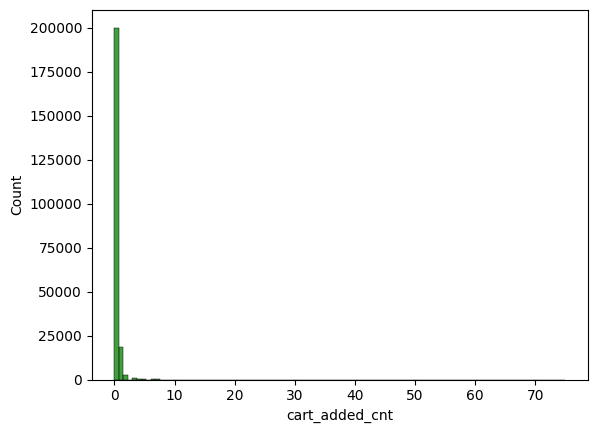

In [15]:
sns.histplot(data=shop_metrics_new, x=TARGET_METRIC, bins=100, color='green')
plt.show()

Глянем на классические стат показатели, видим что как минимум 75% данных нули, но при этом у кого-то количество товаров в корзине достигает 75

In [16]:
shop_metrics_new.groupby('group')[TARGET_METRIC].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


Посмотрим топ 1% перцентиль по количеству товаров, значит больше 6 товаров и ты уже в него попадаешь

In [17]:
np.percentile(shop_metrics_new[TARGET_METRIC], 99.9)

6.0

Посмотрим сколько покупателей в топ 1%, 213 покупателей

In [18]:
shop_metrics_new[shop_metrics_new[TARGET_METRIC] > 6]['user_id'].count()

213

### Мощность и корректность для cart_added_cnt

Дропнем колонку group, чтобы не мешалась

In [19]:
shop = shop_metrics_new.drop(columns=['group'])

Считаем мощность и корректность на t-test

100%|██████████| 1000/1000 [13:20<00:00,  1.25it/s]


0.045735701138158856
 power: 67.10000000000001%, correctness: 95.8%


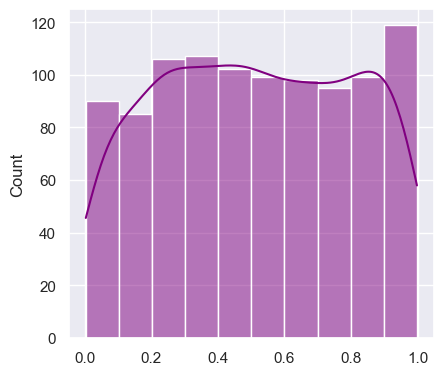

In [22]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')][TARGET_METRIC]
    vec_b = new_df[(new_df['group'] == 'B')][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}%, correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Считаем мощность и корректность на U-test

100%|██████████| 1000/1000 [19:31<00:00,  1.17s/it]


0.05070963940415951
 power: 99.4%, correctness: 95.19999999999999%


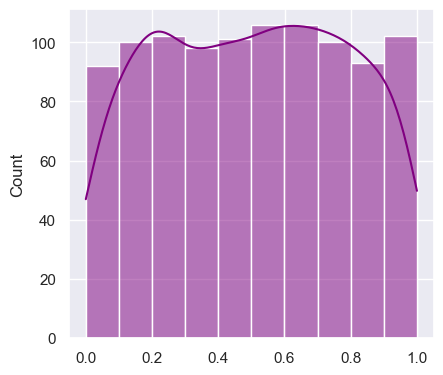

In [23]:
correctness = []
power = []

for i in tqdm(range(1000)): 
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')][TARGET_METRIC]
    vec_b = new_df[(new_df['group'] == 'B')][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}%, correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

ВЫВОД: На U-test'e Манна-Уитни мощность значительно выросла и распределение p-value выглядит более равномерно. Данный критерий больше подходит под наши данные

## 2. CUPED

Создадим функцию и сджойним старые и новые данные, чтобы взять старые как covariate

In [24]:
def cuped_transform(df, metrics):
    new_columns = [str(m + '_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m + '_covariate')
        cuped_column = str(m + '_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

### На обычной метрике

Считаем мощность и корректность для CUPED

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


 power: 100.0% , correctness: 95.0%


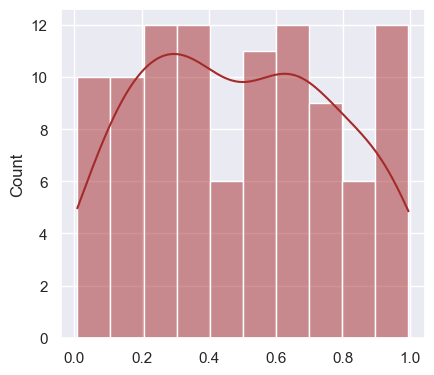

In [27]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
    all_df = all_df.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})

    cuped_df = cuped_transform(all_df, [TARGET_METRIC])

    vec_a = cuped_df[(cuped_df['group'] == 'A')][f'{TARGET_METRIC}_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')][f'{TARGET_METRIC}_cuped']
    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### На прологарифмированной метрике

Создаем логарифмированную метрику

In [30]:
TARGET_METRIC_LN = TARGET_METRIC + "_ln"
shop_metrics_new[TARGET_METRIC_LN] = np.log(shop_metrics_new[TARGET_METRIC] + 1)
shop_metrics_old[TARGET_METRIC_LN] = np.log(shop_metrics_old[TARGET_METRIC] + 1)
shop[TARGET_METRIC_LN] = np.log(shop[TARGET_METRIC] + 1)

Считаем мощность и корректность

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


 power: 100.0% , correctness: 98.0%


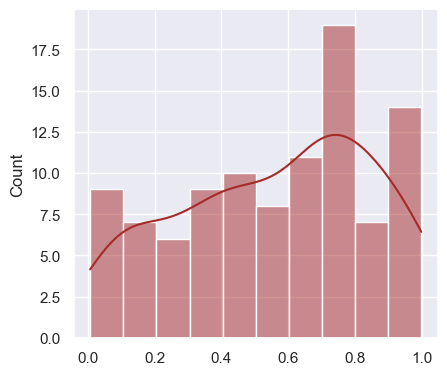

In [31]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', TARGET_METRIC_LN]], on=['user_id'], how='left')
    all_df = all_df.rename(columns={f'{TARGET_METRIC_LN}_x': TARGET_METRIC_LN, f'{TARGET_METRIC_LN}_y': f'{TARGET_METRIC_LN}_covariate'})

    cuped_df = cuped_transform(all_df, [TARGET_METRIC_LN])

    vec_a = cuped_df[(cuped_df['group'] == 'A')][f'{TARGET_METRIC_LN}_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')][f'{TARGET_METRIC_LN}_cuped']
    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

## На обычной + ранговое преобразование

Создадим функцию рангового преобразования

In [32]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    
    return df

Мощность и корректность для ранговой трансформации

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


 power: 100.0% , correctness: 96.0%


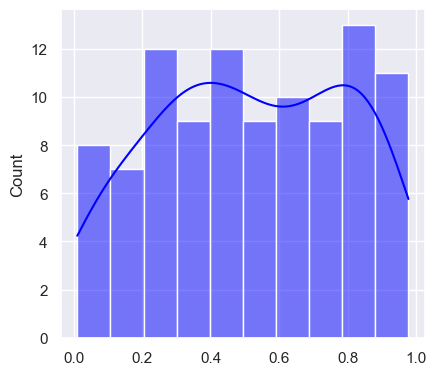

In [34]:
correctness = []
power = []

for i in tqdm(range(100)):
    # сначала cuped
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
    all_df = all_df.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})

    cuped_df = cuped_transform(all_df, [TARGET_METRIC])

    # потом ранговое преобразование по cuped'у
    ranked_df = rank_transformation(cuped_df[cuped_df.group == 'A'], cuped_df[cuped_df.group == 'B'], f'{TARGET_METRIC}_cuped')
    
    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']
    
    vec_b_effect = cuped_df[cuped_df['group'] == 'B'][f'{TARGET_METRIC}_cuped'] * 1.05
    new_df_b = cuped_df[cuped_df.group == 'B'].drop(columns=[f'{TARGET_METRIC}_cuped'])
    new_df_b[f'{TARGET_METRIC}_cuped'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(cuped_df[cuped_df.group == 'A'], new_df_b, f'{TARGET_METRIC}_cuped')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

ВЫВОД: CUPED на исходной метрике уже показал максимальную мощность, можно было бы не идти дальше.

Но при этом видим что все преобразования также дали максимальную мощность, а значит имеют право на существование

## 3. Разбивка на бакеты